<a href="https://colab.research.google.com/github/vincelemke99/Bachelor-Thesis/blob/main/lead_predication_final_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas category_encoders scikit-learn --q




In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Import machine learning libraries
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif

In [ ]:
from google.colab import auth
auth.authenticate_user()
print("Authenticated")

Authenticated


In [ ]:
PROJECT_ID = 'prj-snd-ew3-vschmitt'

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

In [ ]:
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'lead_prediction'
BQ_TABLE = 'trainings_data'

In [ ]:
# SQL query to select data
query = f"""
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""

try:
    # Execute the query and convert the result to a pandas DataFrame
    df = client.query(query=query).to_dataframe()
    print("Query executed successfully and DataFrame is ready.")
except Exception as e:
    print(f"An error occurred: {e}")

Query executed successfully and DataFrame is ready.


In [ ]:
df.shape

(210811, 18)

In [ ]:
df.head()

,Lead_ID,Lead_Source,Lead_Source_Detail,Name_Case,Domain_Type,Gender,Host,has_Phone,Accept_Data_Policy,Conversion_Type,Study_Model,Type_of_Study_Program,Study_Location,Faculty,Study_Program,Semester,is_converted,Sum_of_Study_Interests
0,00Q7U000003RdpLUAS,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,None,Berufsbegleitend,Weiterbildung,Berlin,Fachbereich Design,Styling,Wintersemester,False,1
1,00Q7U000005NeSiUAK,Organisch,Bing,lowercase,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,Hamburg,Fachbereich Design,Styling,Wintersemester,False,1
2,00Q7U0000034VNWUA2,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,None,Berufsbegleitend,Weiterbildung,München,Fachbereich Design,Styling,Sommersemester,False,1
3,00Q7U000006uQDGUA2,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,München,Fachbereich Design,Styling,Sommersemester,False,1
4,00Q7U000008l7alUAA,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,Hamburg,Fachbereich Design,Styling,Wintersemester,True,1


In [ ]:
df.drop(['Lead_ID',], axis="columns", inplace=True)

In [ ]:
df.rename(columns={'Lead_Source' : 'Lead Source', 'Lead_Source_Detail' : 'Lead Source Detail',
                   'Name_Case' : 'Name Case', 'has_Phone' : 'has Phone', 'Accept_Data_Policy' : 'Accept Data Policy',
                   'Conversion_Type' : 'Conversion Type', 'Study_Model' : 'Study Model', 'Type_of_Study_Program' : 'Type of Study Program',
                   'Study_Location' : 'Study Location', 'Study_Program' : 'Study Program', 'Sum_of_Study_Interests' : 'Sum of Study Interests' , 'Domain_Type' : 'Domain Type' },inplace=True)


In [ ]:
df.head()

,Lead Source,Lead Source Detail,Name Case,Domain Type,Gender,Host,has Phone,Accept Data Policy,Conversion Type,Study Model,Type of Study Program,Study Location,Faculty,Study Program,Semester,is_converted,Sum of Study Interests
0,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,None,Berufsbegleitend,Weiterbildung,Berlin,Fachbereich Design,Styling,Wintersemester,False,1
1,Organisch,Bing,lowercase,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,Hamburg,Fachbereich Design,Styling,Wintersemester,False,1
2,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,None,Berufsbegleitend,Weiterbildung,München,Fachbereich Design,Styling,Sommersemester,False,1
3,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,München,Fachbereich Design,Styling,Sommersemester,False,1
4,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,Hamburg,Fachbereich Design,Styling,Wintersemester,True,1


In [ ]:
df.isna().sum().to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
Host,40591
Conversion Type,39412
Gender,3738
Lead Source,0
Lead Source Detail,0
Domain Type,0
Name Case,0
has Phone,0
Accept Data Policy,0
Study Model,0


In [ ]:
# Calculate the percentage of missing values for each column
percentage_missing = df.isnull().sum() * 100 / len(df)
# Create a DataFrame to display the missing values
missing_values_df = percentage_missing.to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)
# Display the DataFrame
missing_values_df

,Missing Values
Host,19.254688
Conversion Type,18.695419
Gender,1.773152
Lead Source,0.000000
Lead Source Detail,0.000000
Domain Type,0.000000
Name Case,0.000000
has Phone,0.000000
Accept Data Policy,0.000000
Study Model,0.000000


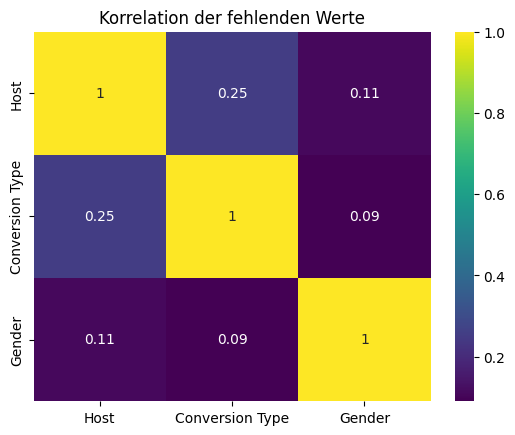

In [ ]:
# Korrelation zwischen den fehlenden Werten
correlation_matrix = df[['Host', 'Conversion Type', 'Gender']].isnull().corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.title('Korrelation der fehlenden Werte')
plt.show()


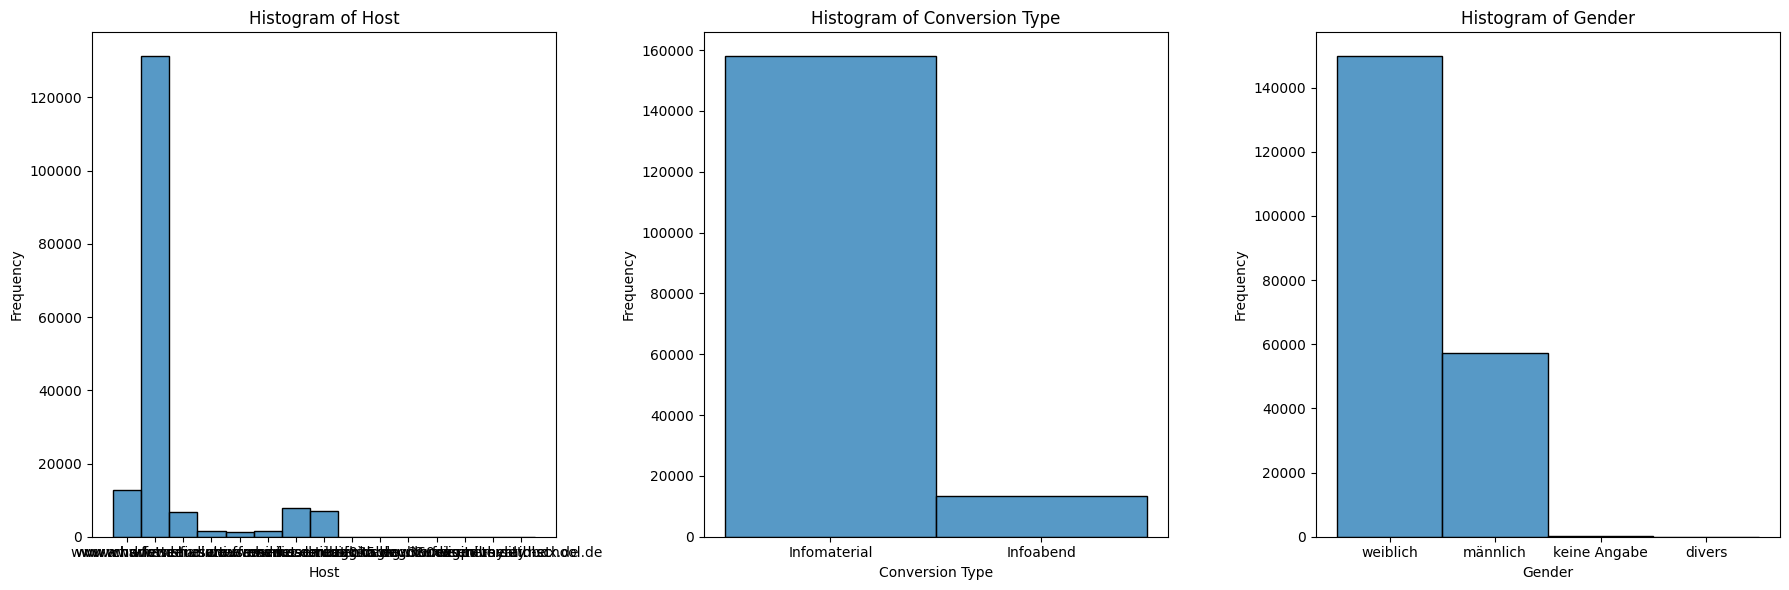

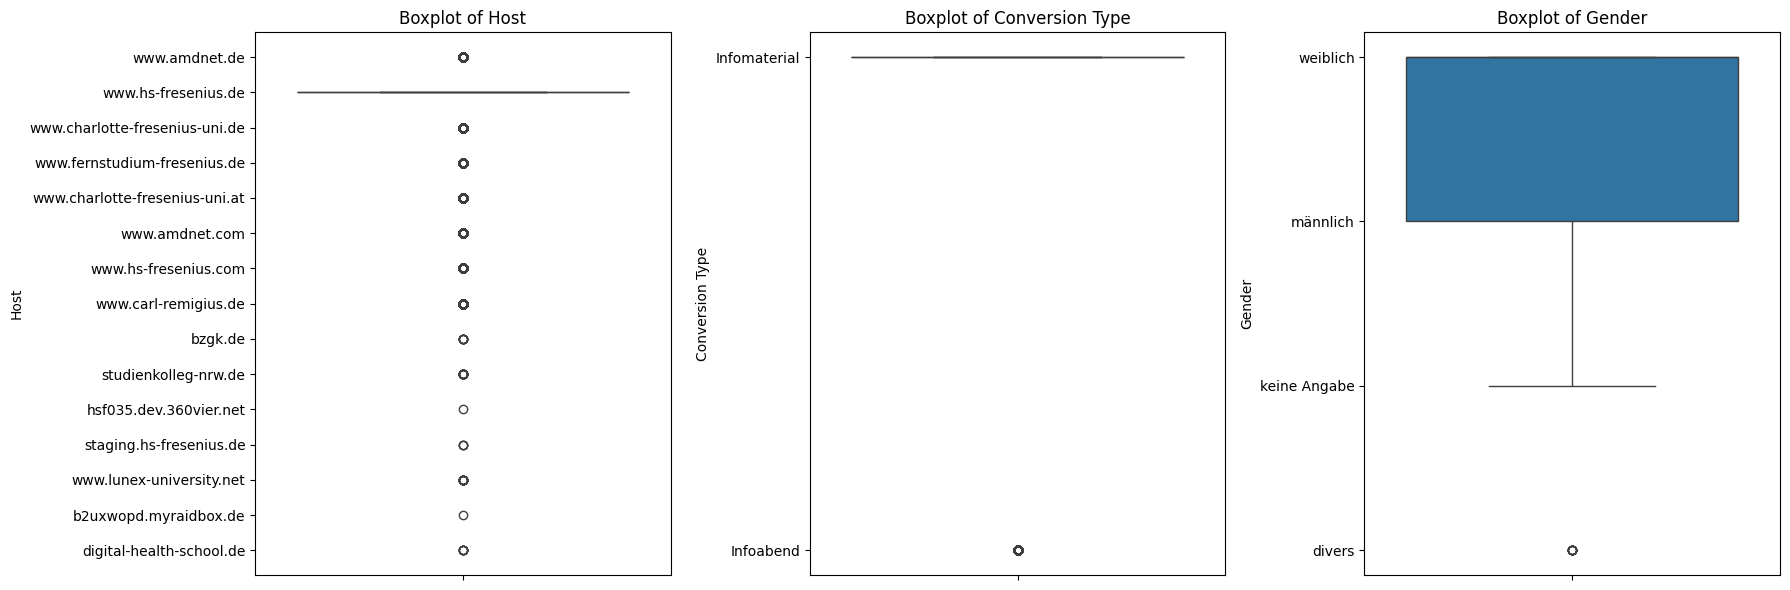

In [ ]:
# Histogramme
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, column in enumerate(['Host', 'Conversion Type', 'Gender']):
    sns.histplot(df[column], kde=False, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Boxplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, column in enumerate(['Host', 'Conversion Type', 'Gender']):
    sns.boxplot(y=df[column], ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_ylabel(column)

plt.tight_layout()
plt.show()

In [ ]:
df['Host'].value_counts()

Host
www.hs-fresenius.de               131236
www.amdnet.de                      12679
www.hs-fresenius.com                7917
www.carl-remigius.de                7067
www.charlotte-fresenius-uni.de      6886
www.amdnet.com                      1578
www.fernstudium-fresenius.de        1503
www.charlotte-fresenius-uni.at      1297
studienkolleg-nrw.de                  23
www.lunex-university.net              16
bzgk.de                                7
digital-health-school.de               6
staging.hs-fresenius.de                3
hsf035.dev.360vier.net                 1
b2uxwopd.myraidbox.de                  1
Name: count, dtype: int64

In [ ]:
unwanted_hosts = ['staging.hs-fresenius.de', 'hsf035.dev.360vier.net', 'b2uxwopd.myraidbox.de', 'digital-health-school.de']

# Filter the DataFrame
df = df[~df['Host'].isin(unwanted_hosts)]

In [ ]:
unwanted_Lead_Source = ['-149307507Publisher', 'Not Found']

# Filter the DataFrame
df = df[~df['Lead Source'].isin(unwanted_Lead_Source )]

In [ ]:
df['Conversion Type'] = df['Conversion Type'].fillna('Infomaterial')

In [ ]:
df['Gender'] = df['Gender'].fillna('weiblich')

In [ ]:
df['Host'] = df['Host'].fillna('www.hs-fresenius.de')

In [ ]:
# Calculate the percentage of missing values for each column
percentage_missing = df.isnull().sum() * 100 / len(df)
# Create a DataFrame to display the missing values
missing_values_df = percentage_missing.to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)
# Display the DataFrame
missing_values_df

,Missing Values
Lead Source,0.0
Lead Source Detail,0.0
Name Case,0.0
Domain Type,0.0
Gender,0.0
Host,0.0
has Phone,0.0
Accept Data Policy,0.0
Conversion Type,0.0
Study Model,0.0


In [ ]:
df.describe()

,Sum of Study Interests
count,210797.0
mean,1.05613
std,0.279028
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,16.0


In [ ]:
df.isna().sum().to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
Lead Source,0
Lead Source Detail,0
Name Case,0
Domain Type,0
Gender,0
Host,0
has Phone,0
Accept Data Policy,0
Conversion Type,0
Study Model,0


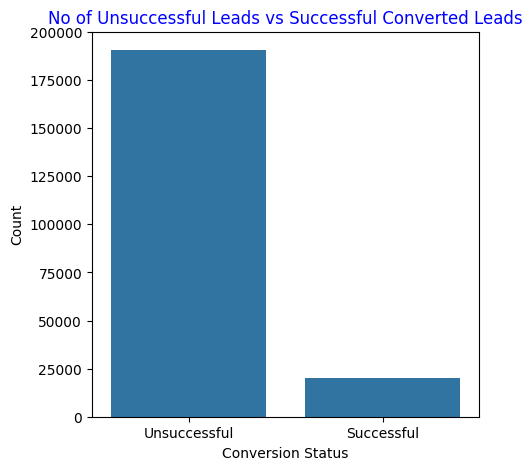

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(x='is_converted', data=df)
plt.title('No of Unsuccessful Leads vs Successful Converted Leads', color='blue')
plt.xticks(np.arange(2), ('Unsuccessful', 'Successful'))
plt.xlabel('Conversion Status')
plt.ylabel('Count')
plt.show()

In [ ]:
total_leads = len(df)
successful_leads = df['is_converted'].sum()
conversion_rate = (successful_leads / total_leads) * 100
print(f'Conversion Rate: {conversion_rate:.2f}%')

Conversion Rate: 9.60%


In [ ]:
# Creating a crosstab DataFrame for demonstration
crosstab_df = pd.crosstab(index=df['Lead Source'], columns='count')

In [ ]:
def plot_frequency_and_percentage(feature, df, category_df, another_row=False, height=8, ylabels=[]):
    if another_row:
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, height * 2))
    else:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # Get top 5 categories by frequency
    top_categories = category_df[feature].value_counts().nlargest(5).index

    # Frequency plot for top 5 categories
    ax1.set_title(f'Frequency Plot of {feature}', color='blue')
    ax1.set_ylabel(feature)
    ax1.set_xlabel('count')
    sns.countplot(y=feature, data=category_df[category_df[feature].isin(top_categories)],
                  order=top_categories, ax=ax1, color='green')
    if ylabels:
        ax1.set_yticklabels(ylabels)

    # Calculate count of converted leads for top 5 categories
    converted_counts = df[df['is_converted'] == True][feature].value_counts()
    converted_counts = converted_counts[converted_counts.index.isin(top_categories)]

    # Converted leads plot for top 5 categories
    ax2.set_title('Converted Leads Count', color='blue')
    ax2.set_ylabel(feature)
    ax2.set_xlabel('count')
    converted_counts.sort_values().plot(kind='barh', ax=ax2, color='orange')
    if ylabels:
        ax2.set_yticklabels(ylabels)

    # Calculate and display overall conversion rate
    total_leads = len(df)
    successful_leads = df['is_converted'].sum()
    conversion_rate = (successful_leads / total_leads) * 100
    fig.suptitle(f'Overall Conversion Rate: {conversion_rate:.2f}%', fontsize=14, color='red')


plt.show()

In [ ]:

def plot_conversion_rate(df, is_converted_column, feature):
    """
    Plots the conversion rate for a specified feature.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    is_converted_column (str): The name of the column indicating if a conversion occurred.
    feature (str): The feature for which to calculate and plot the conversion rate.
    """
    # Filter data where is_converted is True
    df_converted = df[df[is_converted_column] == True]

    # Calculate the count of conversions for each unique value in the feature
    converted_counts = df_converted[feature].value_counts()

    # Calculate the percentage of each unique value within the converted data
    conversion_rate = (converted_counts / converted_counts.sum()) * 100
    conversion_rate = conversion_rate.sort_values(ascending=False)

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    conversion_rate.plot(kind='bar')
    plt.title(f'Percentage of Converted Users by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Percentage of Converted Users (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

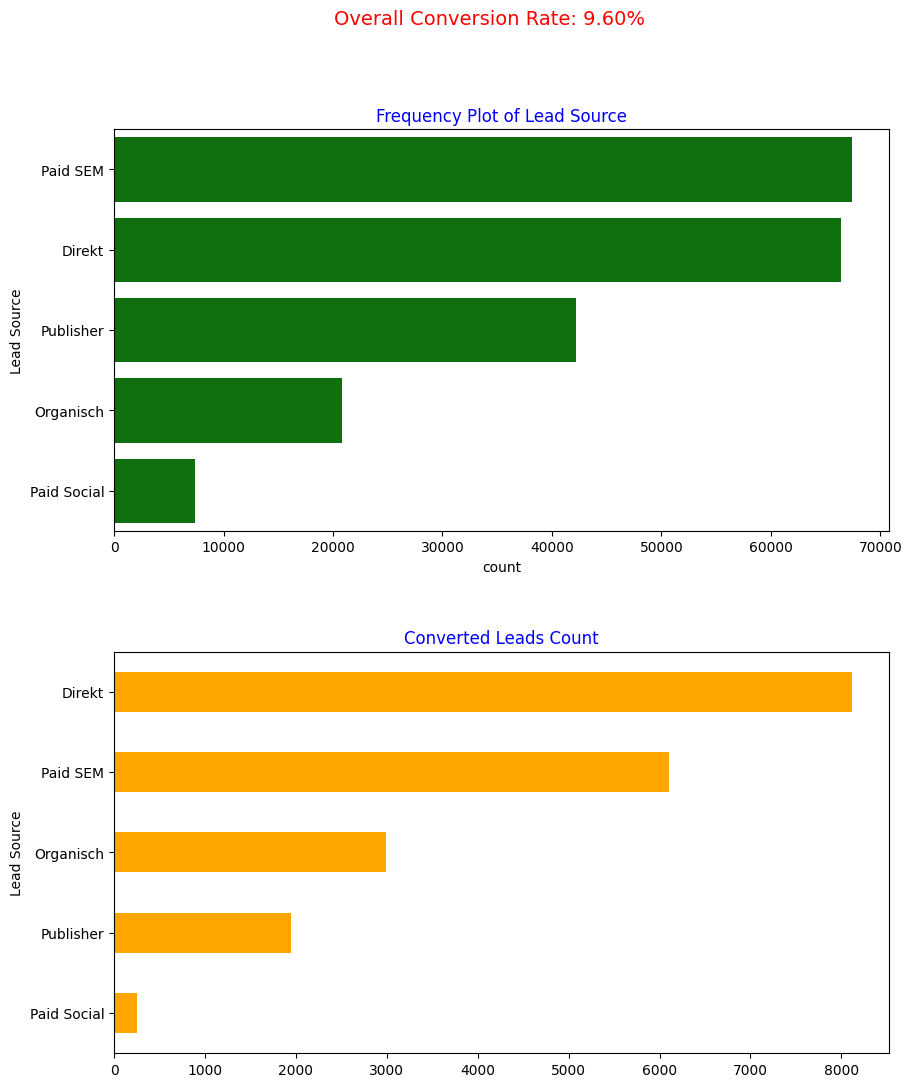

In [ ]:
plot_frequency_and_percentage('Lead Source', df, df, True, 6)

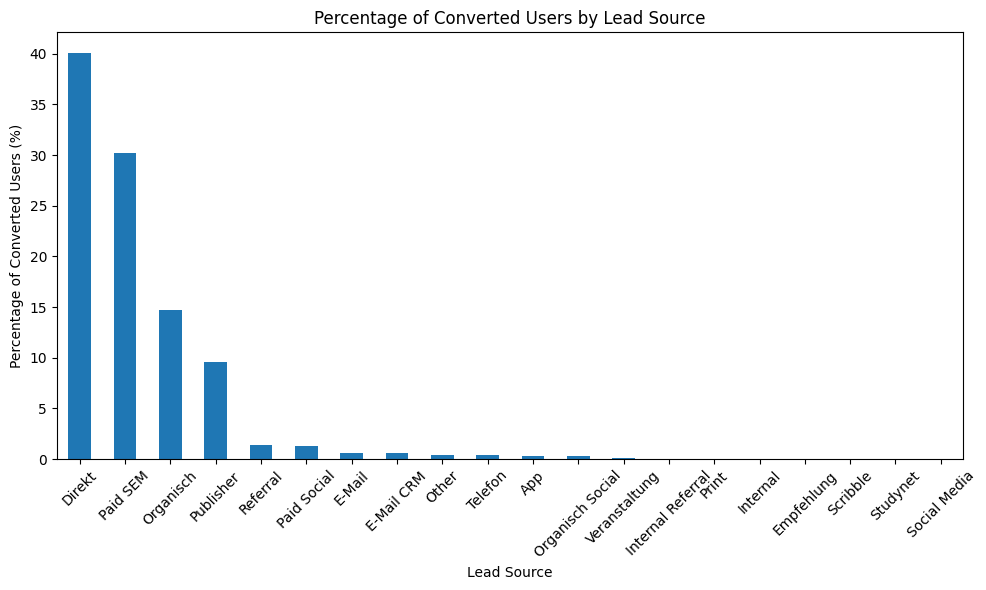

In [ ]:
plot_conversion_rate(df, 'is_converted', 'Lead Source')

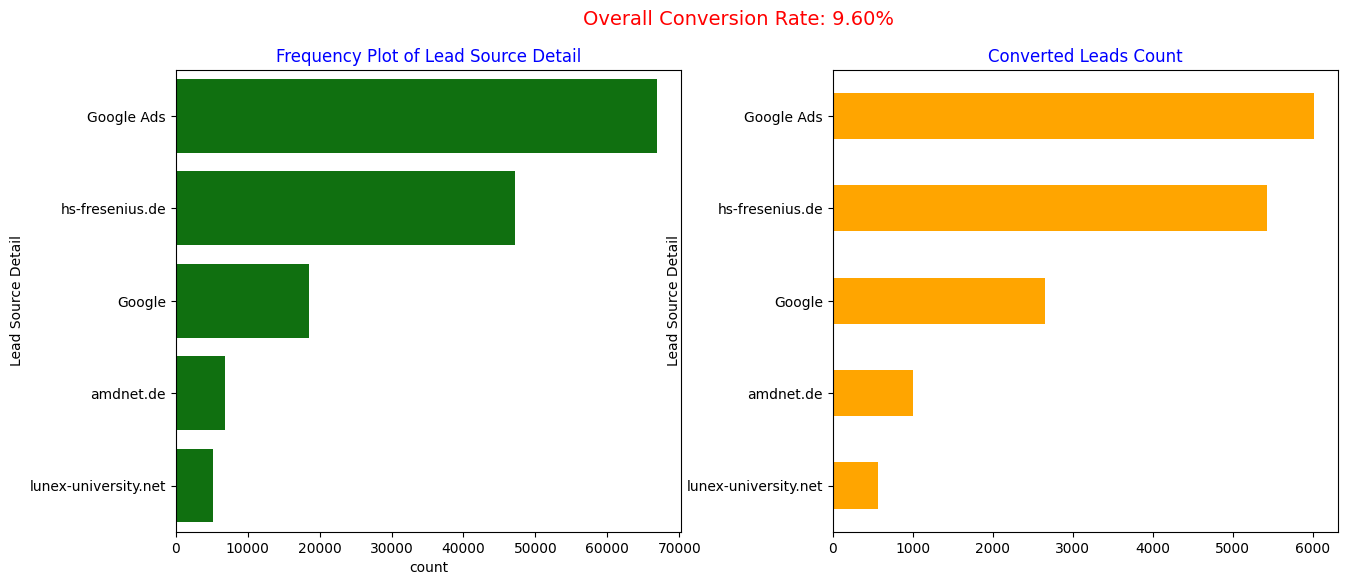

In [ ]:
#plot_frequency_and_percentage('Lead_Source_Detail', df, df, True, 6)
plot_frequency_and_percentage('Lead Source Detail', df, df, another_row=False, height=8, ylabels=[])

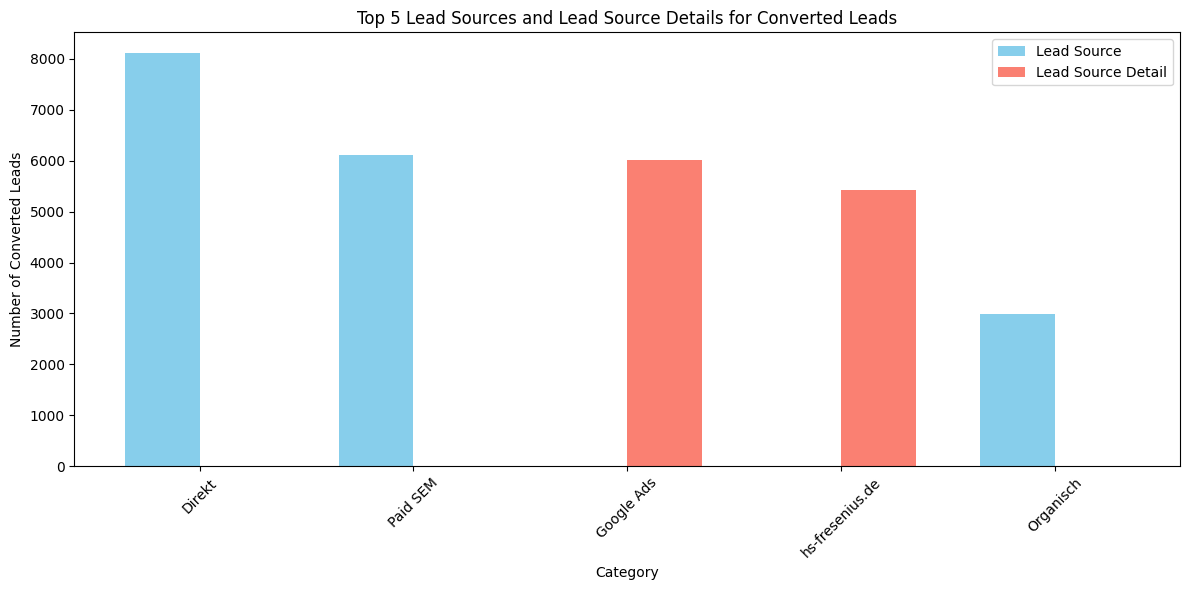

In [ ]:
# Filter for converted leads
converted_leads = df[df['is_converted'] == True]

# Aggregate the data for Lead Source and Lead Source Detail
lead_source_counts = converted_leads['Lead Source'].value_counts()
lead_source_detail_counts = converted_leads['Lead Source Detail'].value_counts()

# Combine the counts into a DataFrame
combined_counts = pd.concat([lead_source_counts, lead_source_detail_counts], axis=1).fillna(0)
combined_counts.columns = ['Lead Source', 'Lead Source Detail']

# Select the top 5 categories overall
top_combined_counts = combined_counts.sum(axis=1).nlargest(5)
top_combined_counts = combined_counts.loc[top_combined_counts.index]

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
index = range(len(top_combined_counts))

# Plot Lead Source bars
lead_source_bars = ax.bar(index, top_combined_counts['Lead Source'], bar_width, label='Lead Source', color='skyblue')

# Plot Lead Source Detail bars next to Lead Source bars
lead_source_detail_bars = ax.bar([i + bar_width for i in index], top_combined_counts['Lead Source Detail'], bar_width, label='Lead Source Detail', color='salmon')

# Add labels, title, and legend
ax.set_xlabel('Category')
ax.set_ylabel('Number of Converted Leads')
ax.set_title('Top 5 Lead Sources and Lead Source Details for Converted Leads')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(top_combined_counts.index, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

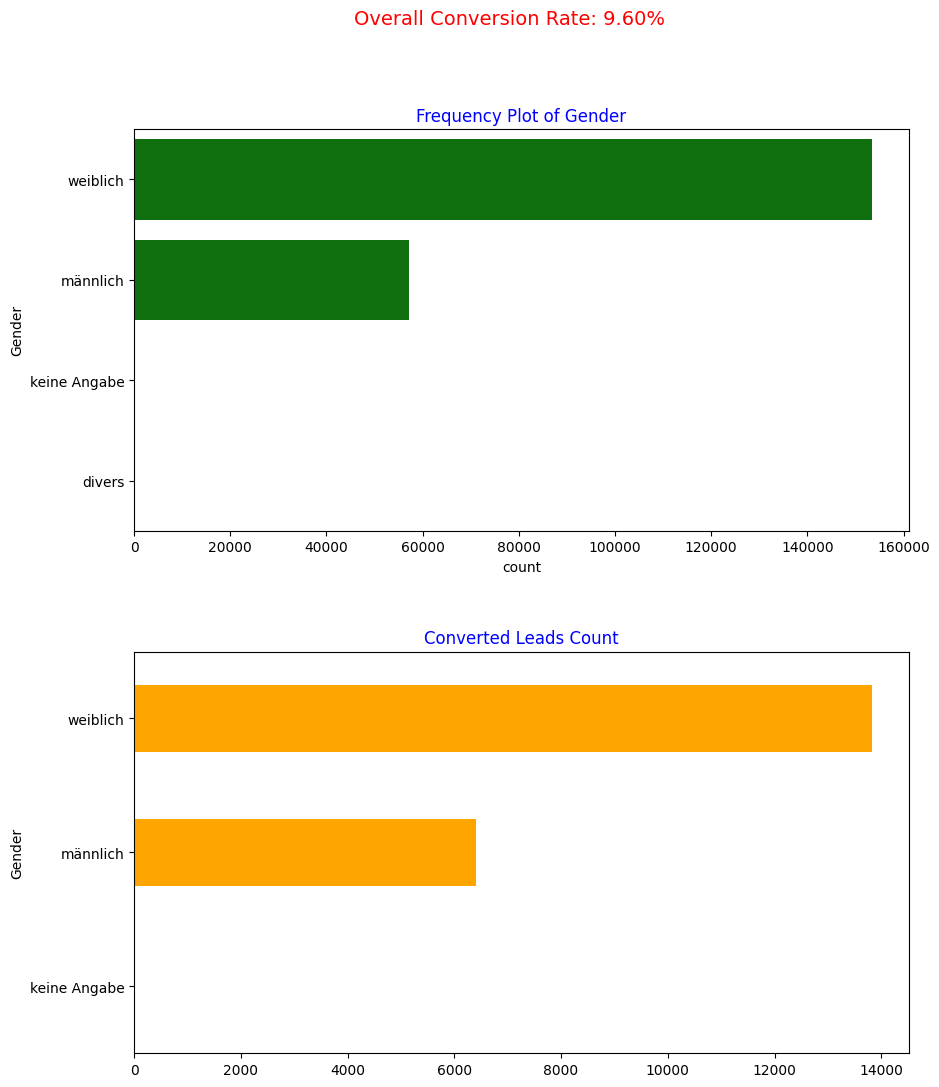

In [ ]:
plot_frequency_and_percentage('Gender', df, df, True, 6)

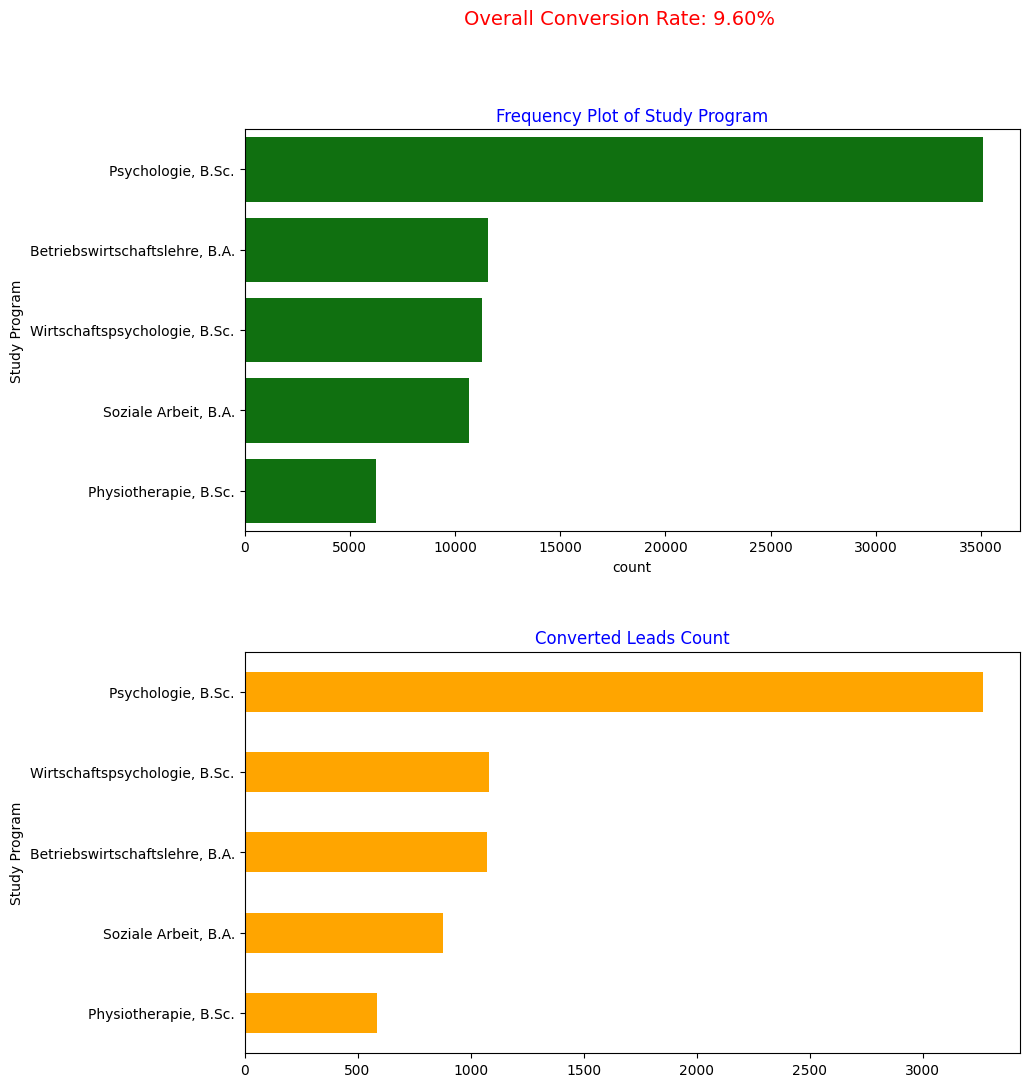

In [ ]:
plot_frequency_and_percentage('Study Program', df, df, True, 6)

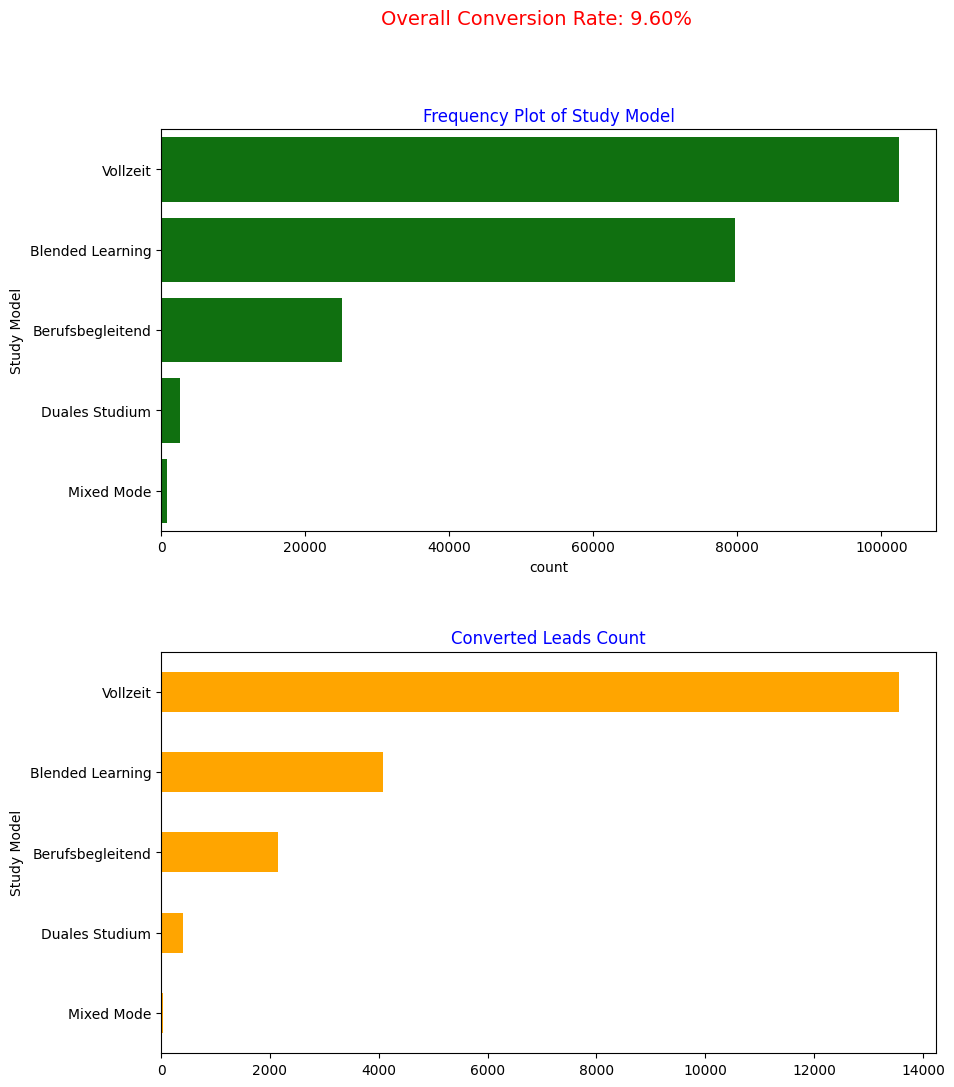

In [ ]:
plot_frequency_and_percentage('Study Model', df, df, True, 6)

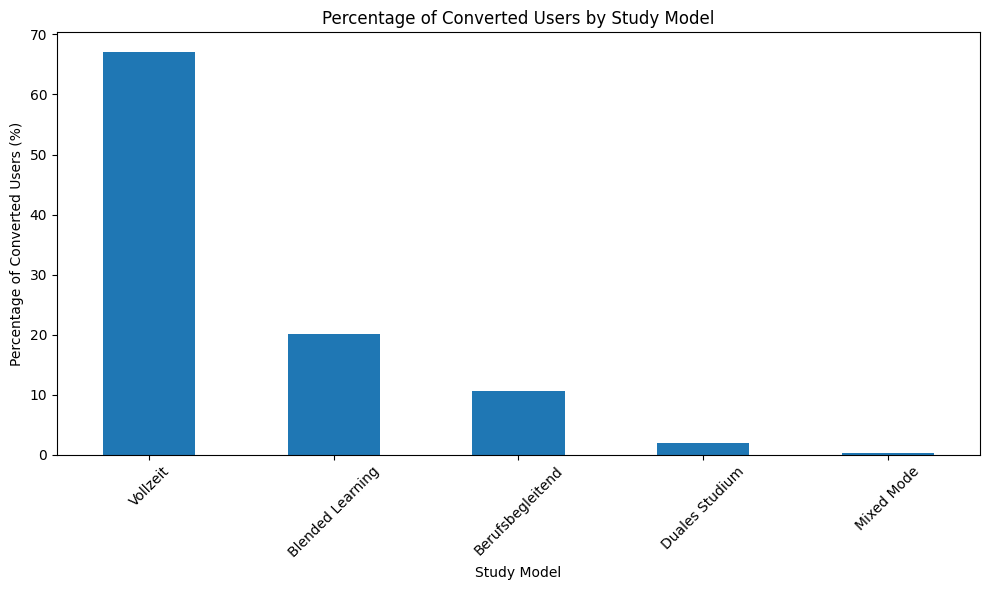

In [ ]:
plot_conversion_rate(df, 'is_converted', 'Study Model')

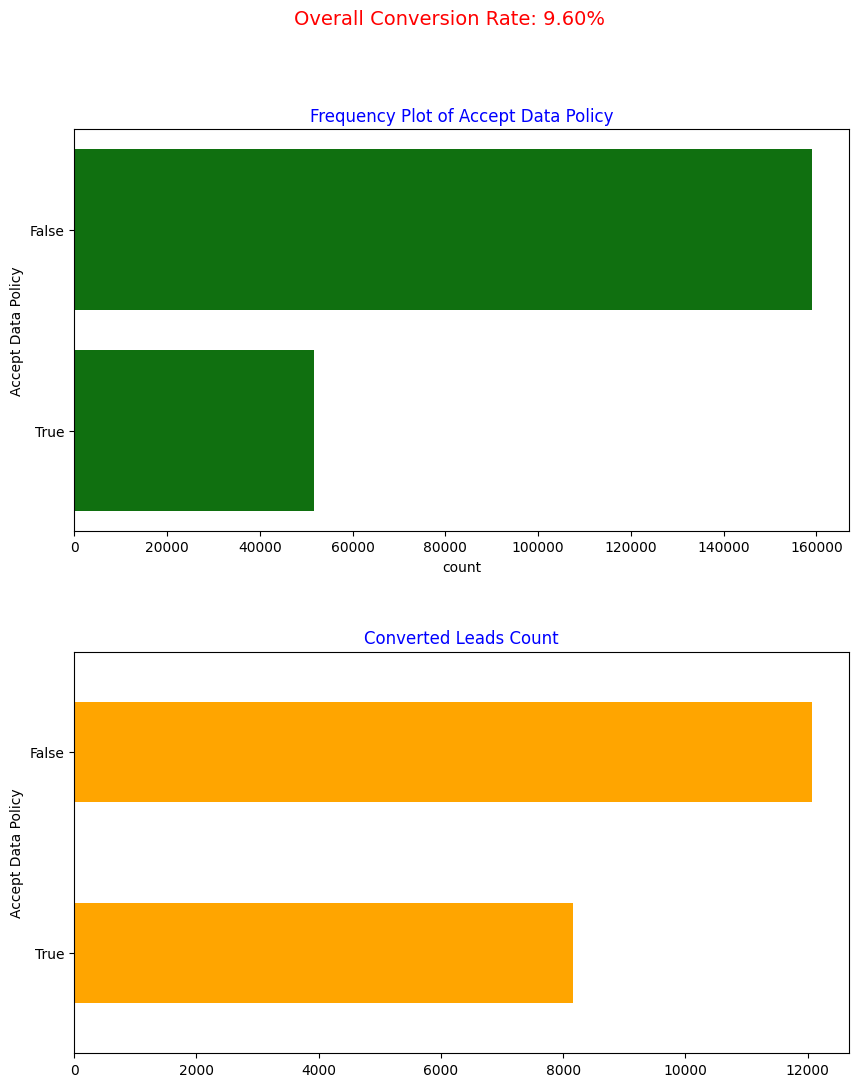

In [ ]:
plot_frequency_and_percentage('Accept Data Policy', df, df, True, 6)

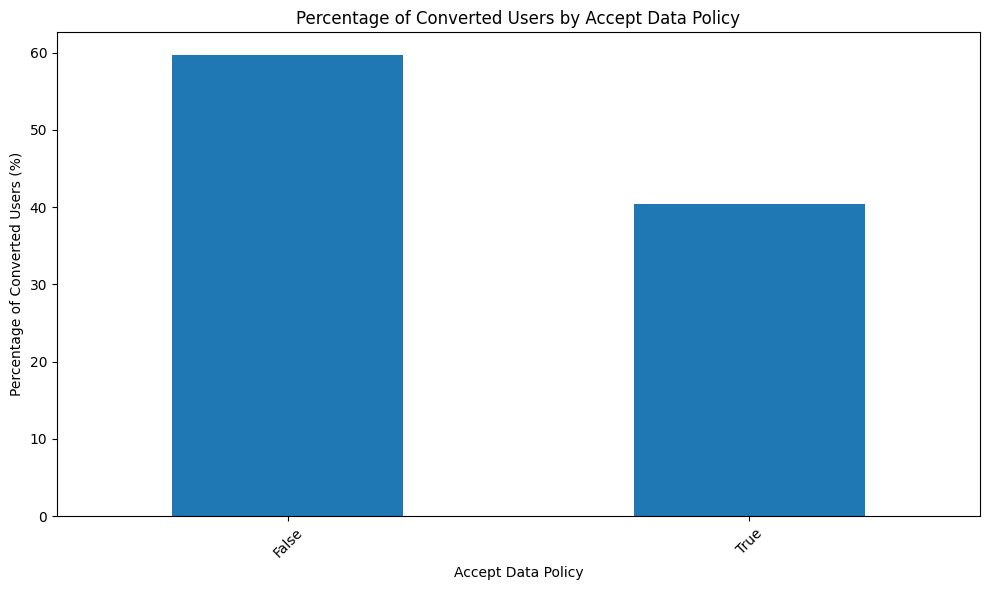

In [ ]:
plot_conversion_rate(df, 'is_converted', 'Accept Data Policy')

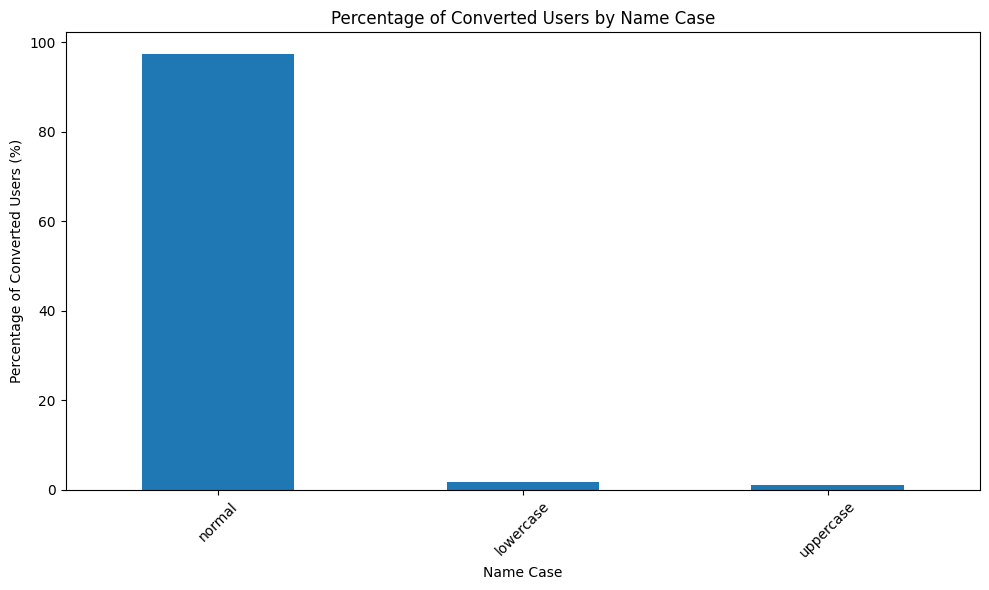

In [ ]:
plot_conversion_rate(df, 'is_converted', 'Name Case')

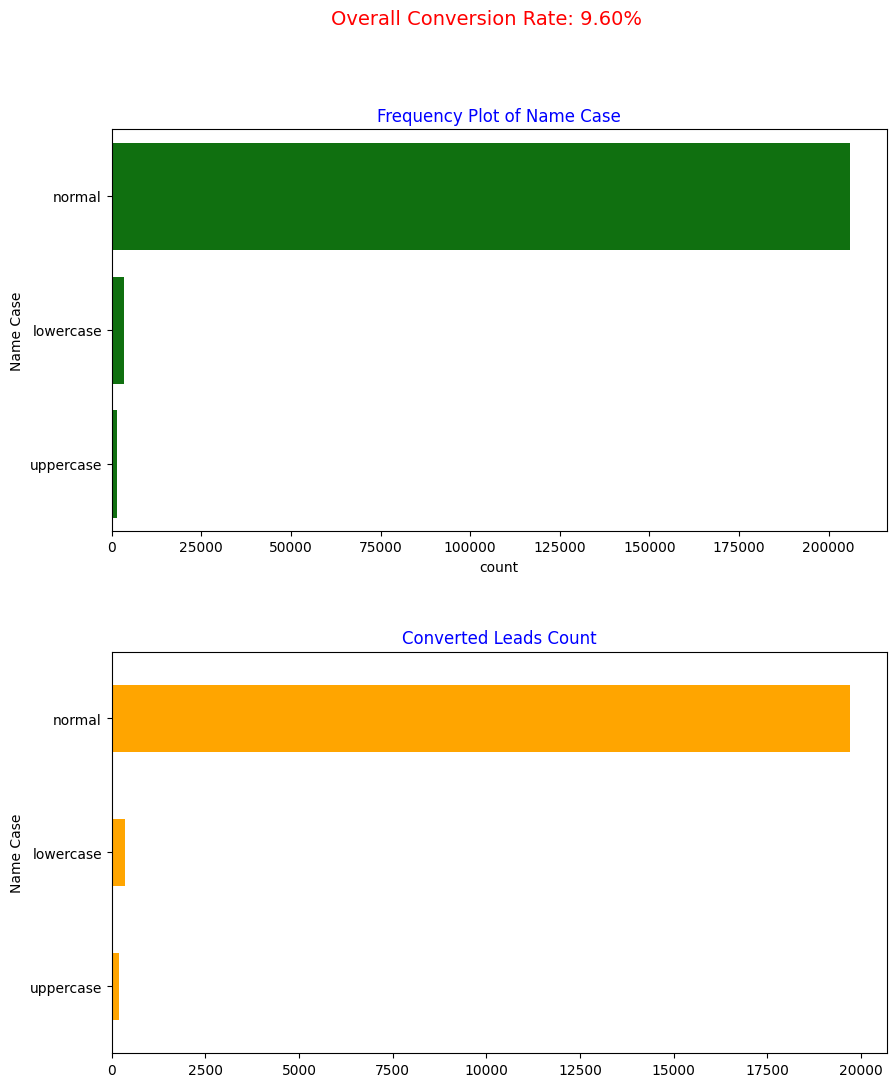

In [ ]:
plot_frequency_and_percentage('Name Case', df, df, True, 6)

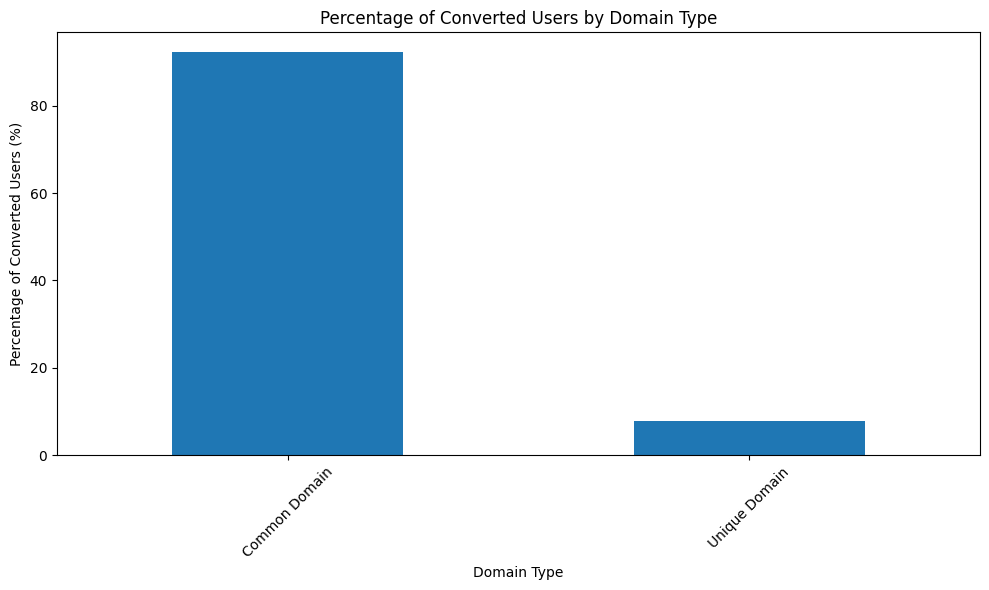

In [ ]:
plot_conversion_rate(df, 'is_converted', 'Domain Type')

In [ ]:
filtered_df = df[df['is_converted'] == True]

# Step 3: Calculate the mean of 's_onTime' for the filtered DataFrame
s_onTime_mean_filtered = filtered_df['Sum of Study Interests'].mean()
print(s_onTime_mean_filtered)

1.1147670569635888


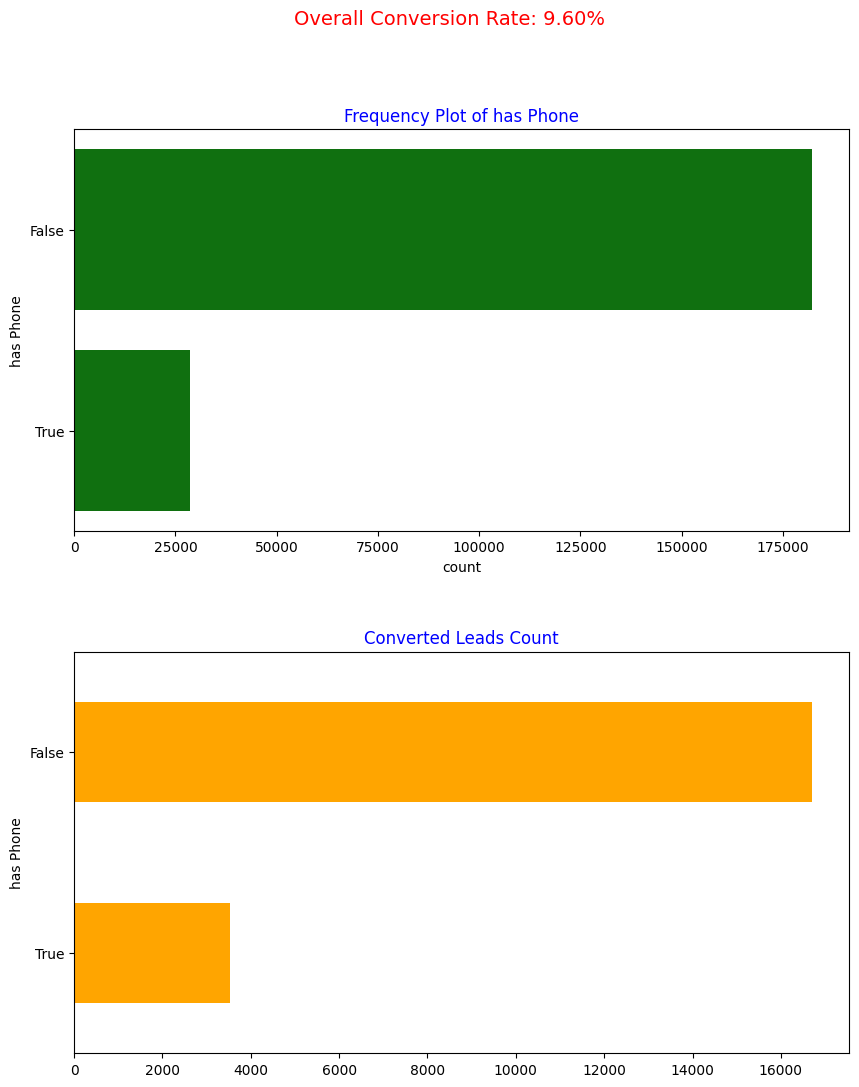

In [ ]:
plot_frequency_and_percentage('has Phone', df, df, True, 6)

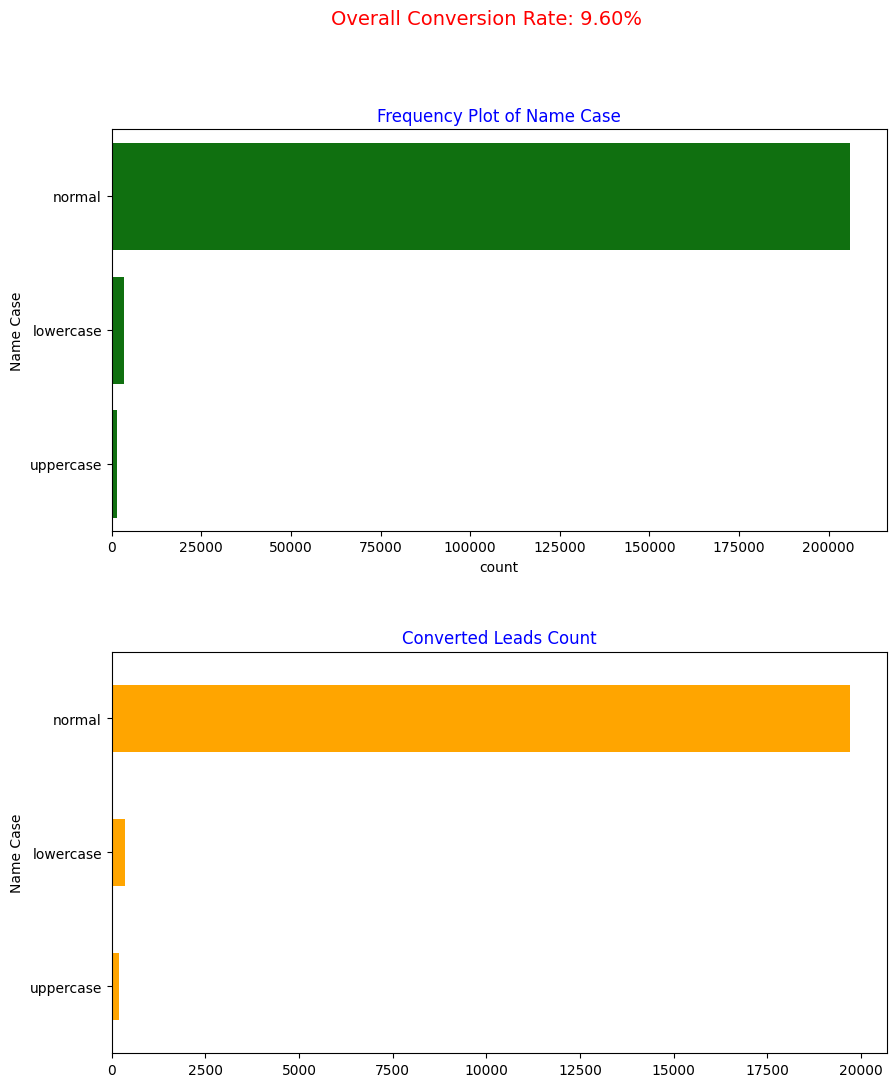

In [ ]:
plot_frequency_and_percentage('Name Case', df, df, True, 6)

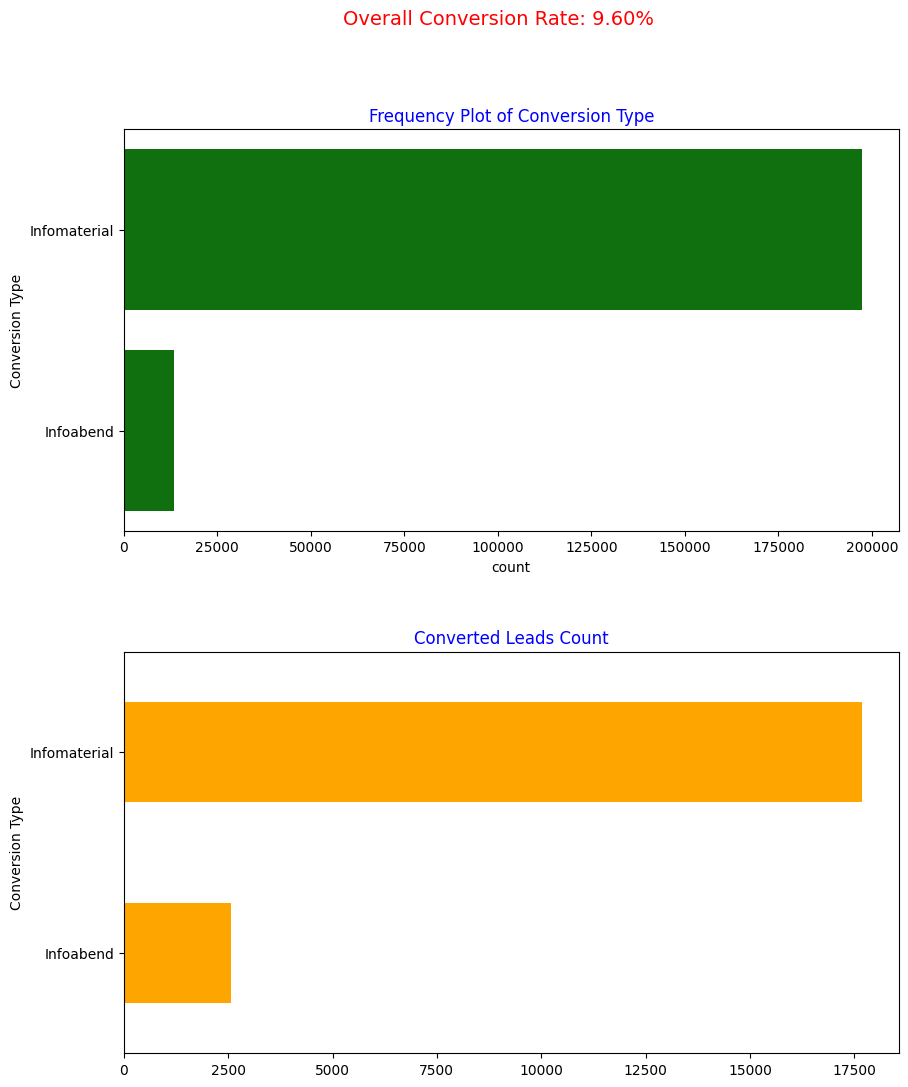

In [ ]:
plot_frequency_and_percentage('Conversion Type', df, df, True, 6)

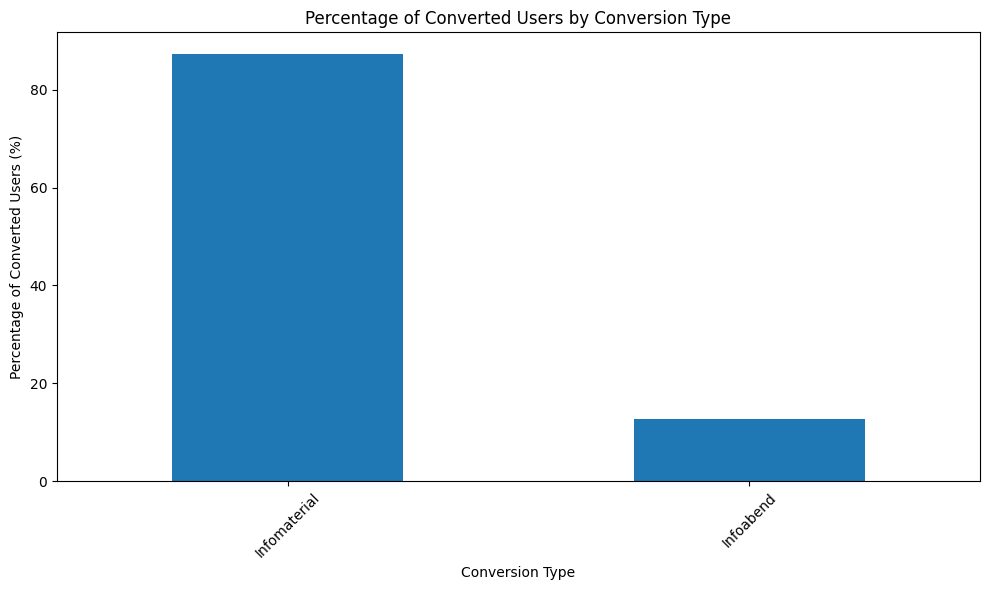

In [ ]:
plot_conversion_rate(df, 'is_converted', 'Conversion Type')

In [ ]:
# Import necessary libraries
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
import category_encoders as ce

In [ ]:
df.dtypes

Lead Source                object
Lead Source Detail         object
Name Case                  object
Domain Type                object
Gender                     object
Host                       object
has Phone                 boolean
Accept Data Policy        boolean
Conversion Type            object
Study Model                object
Type of Study Program      object
Study Location             object
Faculty                    object
Study Program              object
Semester                   object
is_converted              boolean
Sum of Study Interests      Int64
dtype: object

In [ ]:
df.nunique()

Lead Source                24
Lead Source Detail        505
Name Case                   3
Domain Type                 2
Gender                      4
Host                       11
has Phone                   2
Accept Data Policy          2
Conversion Type             2
Study Model                 5
Type of Study Program       6
Study Location             19
Faculty                    10
Study Program             192
Semester                    2
is_converted                2
Sum of Study Interests     11
dtype: int64

In [ ]:
# Create a copy of the dataframe to work with
df_encoded = df.copy()

# Step 1: Drop 'is_converted' column from df_encoded and assign to X_
X = df_encoded.drop(columns=['is_converted'])

# Step 2: Extract 'is_converted' column from df_encoded and assign to y
y = df_encoded['is_converted']

In [ ]:
# Step 3: Label Encoding for specified column

#binary_features = ['Lead Source Detail', 'Study Program']
##encoder_target = ce.TargetEncoder(cols=binary_features)
#X = encoder_target.fit_transform(X, y)

one_hot_features = ['Host', 'Conversion Type', 'Gender', 'Study Model',  'Faculty', 'Study Location', 'Type of Study Program',
                  'Lead Source', 'Accept Data Policy', 'has Phone', 'Domain Type', 'Name Case', 'Lead Source Detail', 'Study Program', 'Semester']

X = pd.get_dummies(X, columns=one_hot_features)

# Step 6: Scaling the dataframe
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Step 7: Define the encoded and scaled dataframe as X_prep
X_en = df_scaled

In [ ]:
# Step 4: Identify categorical features indices for SMOTENC
#categorical_columns = [col for col in X.columns if col not in ['Sum of Study Interests']]

#all_columns = X_en.columns.tolist()
#categorical_indices = [all_columns.index(col) for col in categorical_columns if col in all_columns]


In [ ]:
lb = LabelEncoder()
lb.fit(y)
y_encoded = lb.transform(y)
print("Encoded labels:",lb.classes_)
y_en = pd.Series(y_encoded)

Encoded labels: [0. 1.]


In [ ]:
categorical_columns = [col for col in one_hot_features]

# Since one_hot_features is a list, all_columns is just one_hot_features
all_columns = one_hot_features
categorical_indices = [all_columns.index(col) for col in categorical_columns if col in all_columns]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_en, y_en, test_size=0.2, stratify=y, random_state=42)


print("Training Data Shape : ", X_train.shape, y_train.shape)
print("Test Data Shape : ", X_test.shape, y_test.shape)

Training Data Shape :  (168637, 790) (168637,)
Test Data Shape :  (42160, 790) (42160,)


In [ ]:
from imblearn.over_sampling import SMOTE


# Initialize SMOTENC with Nearest Neighbors Estimator
smote= SMOTE(random_state=42)

# Fit and resample the training data
X_train, y_train = smote.fit_resample(X_train, y_train)


In [ ]:
print("Smote Train Data : ", X_train.shape, y_train.shape)

Smote Train Data :  (304888, 790) (304888,)


In [ ]:
# Compute Mutual Information scores
mi_classification = mutual_info_classif(X_train, y_train, discrete_features='auto')

# Create a pandas Series with the MI scores and the feature names
mi_series = pd.Series(mi_classification, index=X_train.columns)

# Exclude the specified column
mi_series = mi_series.drop(labels='Sum of Study Interests')

# Sort the MI scores in descending order and convert to a DataFrame
data_mi = mi_series.sort_values(ascending=False).to_frame(name='MI')

# Display the DataFrame
print(data_mi)


                                                        MI
Accept Data Policy_True                           0.089515
Accept Data Policy_False                          0.088011
Gender_männlich                                   0.081098
Semester_Sommersemester                           0.081035
Semester_Wintersemester                           0.080820
...                                                    ...
Lead Source Detail_letudiant.fr                   0.000000
Lead Source Detail_linkedin.com                   0.000000
Lead Source Detail_gamecampus.de                  0.000000
Lead Source Detail_gesund-und-aktiv.blogspot.com  0.000000
Lead Source Detail_linktr.ee                      0.000000

[789 rows x 1 columns]


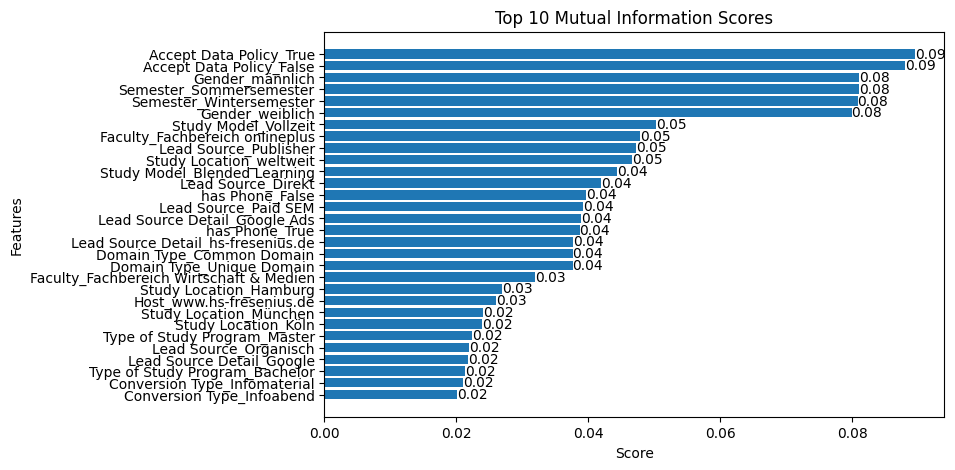

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot the Mutual Information scores
def plot_mi_scores(scores):
    # Select top 10 scores
    top_scores = scores.sort_values(ascending=False).head(30)
    sorted_scores = top_scores.sort_values(ascending=True)
    width = np.arange(len(sorted_scores))
    ticks = sorted_scores.index
    plt.barh(width, sorted_scores)
    plt.yticks(width, ticks)
    plt.title("Top 10 Mutual Information Scores")
    plt.xlabel("Score")
    plt.ylabel("Features")

    # Add text annotations for the bar values
    for index, value in enumerate(sorted_scores):
        plt.text(value, index, f'{value:.2f}', va='center', ha='left')

    plt.show()

# Plot the Mutual Information scores
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_series)



In [ ]:
one_hot_features = ['Host', 'Conversion Type', 'Gender', 'Study Model',  'Faculty', 'Study Location', 'Type of Study Program',
                  'Lead Source', 'Accept Data Policy', 'has Phone', 'Domain Type', 'Name Case', 'Lead Source Detail', 'Study Program', 'Semester']  # Replace with actual prefixes
aggregated_mi = {}
for col in mi_series.index:
    if any(prefix in col for prefix in one_hot_features):
        original_col = next(prefix for prefix in one_hot_features if prefix in col)
        if original_col not in aggregated_mi:
            aggregated_mi[original_col] = 0
        aggregated_mi[original_col] += mi_series[col]
    else:
        aggregated_mi[col] = mi_series[col]

# Convert the aggregated MI scores to a DataFrame
aggregated_mi_series = pd.Series(aggregated_mi)
data_mi = aggregated_mi_series.sort_values(ascending=False).to_frame(name='MI')

# Display the DataFrame
print(data_mi)

                             MI
Lead Source            0.743400
Study Program          0.409363
Study Location         0.207399
Accept Data Policy     0.177526
Gender                 0.162362
Semester               0.161856
Faculty                0.136836
Study Model            0.119366
has Phone              0.078305
Host                   0.078159
Domain Type            0.075247
Type of Study Program  0.050087
Conversion Type        0.041141
Name Case              0.024926


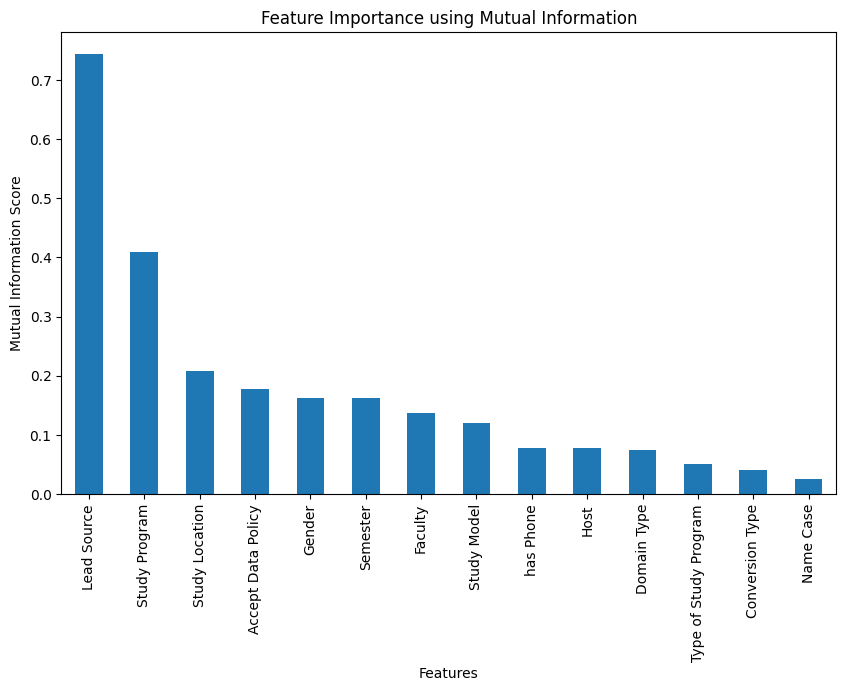

In [ ]:
plt.figure(figsize=(10, 6))
data_mi['MI'].plot(kind='bar')
plt.title('Feature Importance using Mutual Information')
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.show()

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.feature_selection import f_classif
from scipy import stats

X = df[['Sum of Study Interests']]
y = df['is_converted']

# Apply ANOVA F-test
f_values, p_values = f_classif(X, y)

# Create a DataFrame to display the F-scores and p-values for the specific feature
anova_results = pd.DataFrame({
    'Feature': ['Sum of Study Interests'],
    'F-Score': f_values,
    'p-Value': p_values
})

# Select the feature (in this case, it's already just one)
selected_feature = anova_results.iloc[0]

print("Selected feature based on ANOVA F-test:")
print(selected_feature)

Selected feature based on ANOVA F-test:
Feature    Sum of Study Interests
F-Score                 993.49306
p-Value                       0.0
Name: 0, dtype: object


In [ ]:
from sklearn.model_selection import cross_validate, StratifiedKFold
cv_split = StratifiedKFold(n_splits=10)

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, proba)

    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    # Cross Validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall (Sensitivity): {recall}")
    print(f"F1-Score: {f1}")
    print(f"Specificity: {specificity}")
    print(f"ROC AUC: {roc_auc}")
    print(f"Cross Validation Accuracy: {cv_scores.mean()}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

    # Confusion Matrix Visualization
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'specificity': specificity,
        'cv_accuracy': cv_scores.mean()
    }


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
# Pipelines for each model without hyperparameter tuning

pipeline_xgb = Pipeline([
    ('clf', xgb.XGBClassifier())
])

pipeline_rf = Pipeline([
    ('clf', RandomForestClassifier())
])


pipeline_dt = Pipeline([
    ('clf', DecisionTreeClassifier())
])



In [ ]:

model_performance = {}

XGBoost Metrics:
Accuracy: 0.8372390891840608
Precision: 0.21655922643029815
Recall (Sensitivity): 0.26556324110671936
F1-Score: 0.23857079449622728
Specificity: 0.8979586481947943
ROC AUC: 0.6912433550853236
Cross Validation Accuracy: 0.8345328891446009


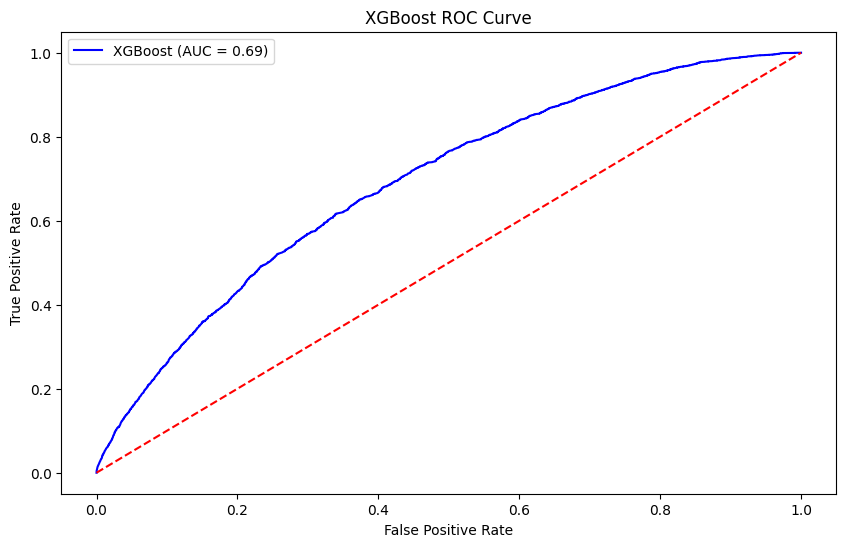

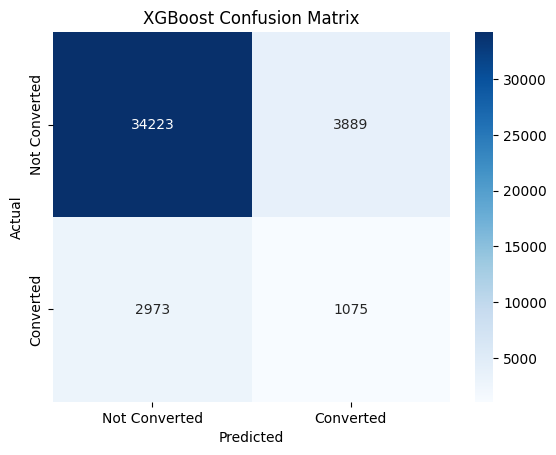

In [ ]:
# Train and evaluate XGBoost
model_performance['XGBoost'] = evaluate_model(pipeline_xgb.fit(X_train, y_train),X_test, y_test, "XGBoost")


RandomForest Metrics:
Accuracy: 0.8213946869070209
Precision: 0.18988243676522978
Recall (Sensitivity): 0.2633399209486166
F1-Score: 0.22065824880977022
Specificity: 0.8806675062972292
ROC AUC: 0.641468659021009
Cross Validation Accuracy: 0.8600897861482251


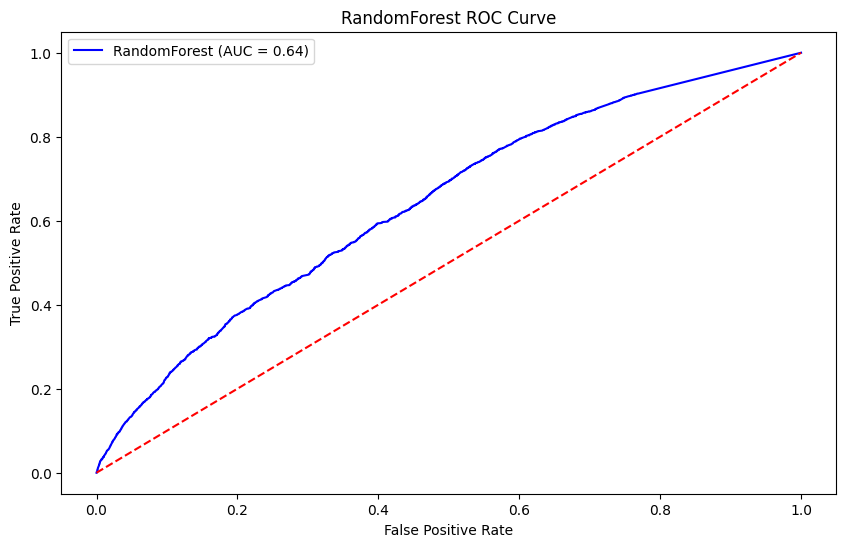

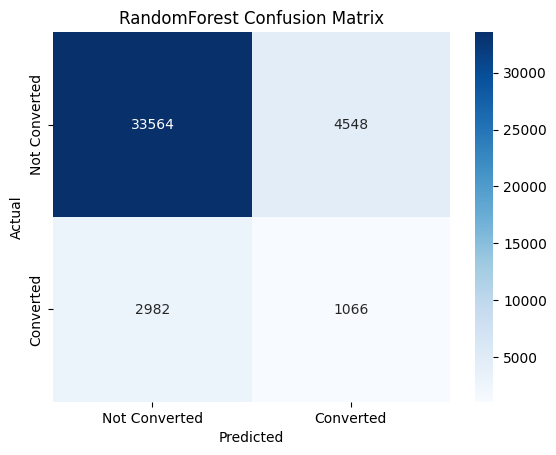

In [ ]:
# Train and evaluate RandomForest
model_performance['RandomForest'] = evaluate_model(pipeline_rf.fit(X_train, y_train), X_test, y_test, "RandomForest")

DecisionTree Metrics:
Accuracy: 0.8154174573055029
Precision: 0.18862575050033356
Recall (Sensitivity): 0.27939723320158105
F1-Score: 0.22520908004778972
Specificity: 0.8723499160369438
ROC AUC: 0.5919275519697716
Cross Validation Accuracy: 0.8514636642079111


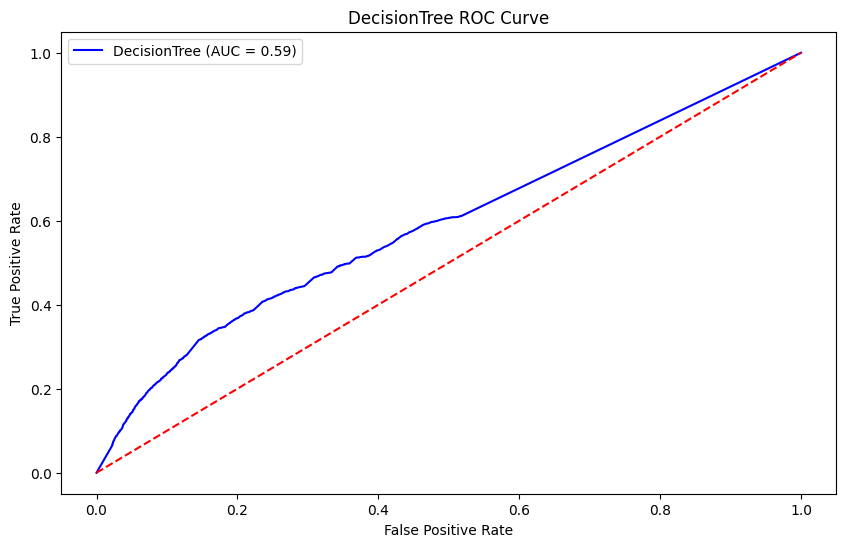

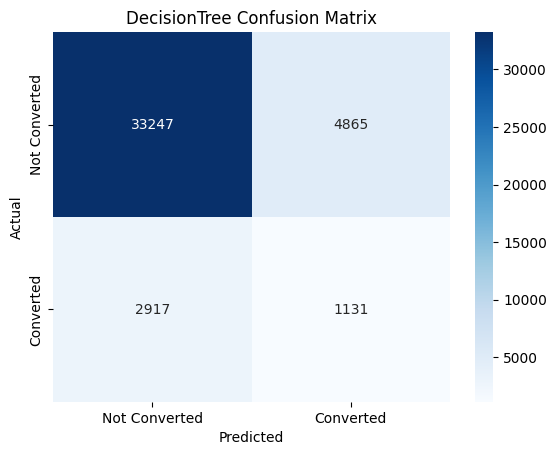

In [ ]:
# Train and evaluate DecisionTree
model_performance['DecisionTree'] = evaluate_model(pipeline_dt.fit(X_train, y_train), X_test, y_test, "DecisionTree")


In [ ]:
# Convert the model performance dictionary to a DataFrame
results_df = pd.DataFrame(model_performance).T

# Save the DataFrame to an Excel file
results_df.to_excel('model_performance_results5.xlsx', index=True)
print("Model performance results saved to 'model_performance_results_final.xlsx'.")

Model performance results saved to 'model_performance_results_final.xlsx'.


In [ ]:
# Determine the best model based on ROC AUC
best_model_name = max(model_performance, key=lambda k: model_performance[k]['roc_auc'])
print(f"The best model is {best_model_name} based on ROC AUC.")


The best model is XGBoost based on ROC AUC.


In [ ]:
 #Define hyperparameters for Grid Search
from scipy.stats import uniform

param_grid_xgb = {
    #'clf__max_depth': [3, 5, 7],
    #'clf__learning_rate': [0.1, 0.01],
    #'clf__n_estimators': [100, 200]

'clf__max_depth': [3, 5, 7, 9],
    'clf__learning_rate': uniform(0.001, 0.1),
    'clf__n_estimators': [100, 200, 300],
    'clf__subsample': uniform(0.6, 0.4),
    'clf__colsample_bytree': uniform(0.6, 0.4),
    'clf__gamma': uniform(0, 0.2),
    'clf__min_child_weight': [1, 3, 5],
    'clf__reg_alpha': uniform(0, 0.5),
    'clf__reg_lambda': uniform(1, 1)
}


param_grid_rf = {
    #'clf__n_estimators': [100, 200],
    #'clf__max_depth': [None, 10, 20]
    'clf__n_estimators': [100, 200, 300, 500],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
    'clf__bootstrap': [True, False]
}

param_grid_dt = {
    #'clf__max_depth': [None, 10, 20],
    #'clf__min_samples_split': [2, 10, 20]
    'clf__n_estimators': [100, 200, 300, 500],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['auto', 'sqrt', 'log2'],
    'clf__bootstrap': [True, False]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
#Function to perform Grid Search
def perform_grid_search(pipeline, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    return grid_search

In [ ]:
def perform_randomized_search(pipeline, param_distributions, X_train, y_train, n_iter=50):
    random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distributions,
                                       n_iter=n_iter, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train, y_train)
    return random_search

In [ ]:
# Perform Grid Search for each model
#grid_search_lgb = perform_grid_search(pipeline_lgb, param_grid_lgb, X_train, y_train)
grid_search_xgb = perform_grid_search(pipeline_xgb, param_grid_xgb, X_train, y_train)
grid_search_rf = perform_grid_search(pipeline_rf, param_grid_rf, X_train, y_train)
grid_search_dt = perform_grid_search(pipeline_dt, param_grid_dt, X_train, y_train)


TypeError: Parameter grid for parameter 'clf__learning_rate' needs to be a list or a numpy array, but got <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78ad6cb5c760> (of type rv_continuous_frozen) instead. Single values need to be wrapped in a list with one element.

In [ ]:
# Perform Randomized Search for each model
random_search_xgb = perform_randomized_search(pipeline_xgb, param_grid_xgb, X_train, y_train)
#random_search_rf = perform_randomized_search(pipeline_rf, param_grid_rf, X_train, y_train)
#random_search_dt = perform_randomized_search(pipeline_dt, param_grid_dt, X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# Evaluate models and store performance
model_performance = {}
# Function to evaluate model
def evaluate_model(grid_search, X_test, y_test, model_name, X_train, y_train):
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

    cm = confusion_matrix(y_test, y_pred)
    tn = cm[0][0]
    fp = cm[0][1] if len(cm[0]) > 1 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')

    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall (Sensitivity): {recall}")
    print(f"F1-Score: {f1}")
    print(f"Specificity: {specificity}")
    print(f"ROC AUC: {roc_auc}")
    print(f"Cross Validation Accuracy: {cv_scores.mean()}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

    # Confusion Matrix Visualization
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'specificity': specificity,
        'cv_accuracy': cv_scores.mean(),
        'best_params': grid_search.best_params_
    }

XGBoost Metrics:
Accuracy: 0.8405834914611006
Precision: 0.8521436161373035
Recall (Sensitivity): 0.8405834914611006
F1-Score: 0.8461516202906927
Specificity: 0.9027078085642317
ROC AUC: 0.688558564153956
Cross Validation Accuracy: 0.8393248199226898


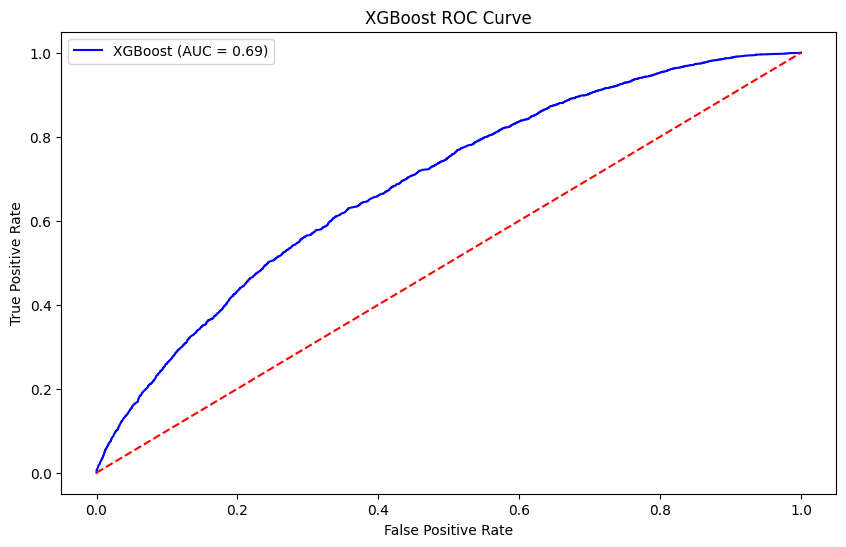

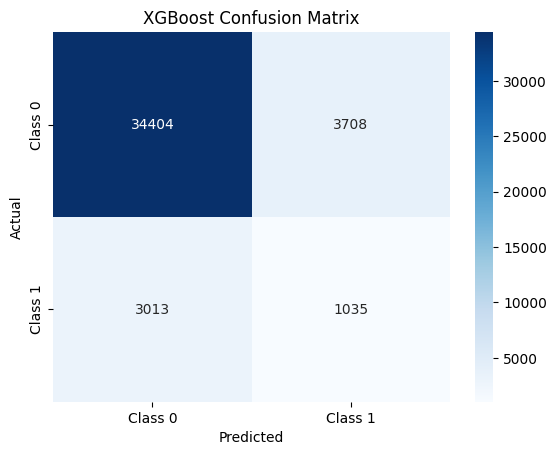

In [ ]:
model_performance['XGBoost'] = evaluate_model(random_search_xgb, X_test, y_test, 'XGBoost', X_train, y_train)

In [ ]:
model_performance['RandomForest'] = evaluate_model(grid_search_rf, X_test, y_test, 'RandomForest', X_train, y_train)

In [ ]:
model_performance['DecisionTree'] = evaluate_model(grid_search_dt, X_test, y_test, 'DecisionTree', X_train, y_train)

In [ ]:
# Convert the model performance dictionary to a DataFrame
results_df = pd.DataFrame(model_performance).T

# Save results to an Excel file
results_df.to_excel('model_performance_metrics_final.xlsx', index=True)

# Print results for each model
print("Model Performance Metrics:")
print(results_df)


Model Performance Metrics:
         accuracy                                        best_params  \
XGBoost  0.840583  {'clf__colsample_bytree': 0.7177795568278342, ...   

        cv_accuracy        f1 precision    recall   roc_auc specificity  
XGBoost    0.839325  0.846152  0.852144  0.840583  0.688559    0.902708  


In [ ]:
query = """
SELECT *
FROM `prj-snd-ew3-vschmitt.lead_prediction.validation_data`
"""

try:
    df = client.query(query=query).to_dataframe()
    print("Query executed successfully and DataFrame is ready.")
except Exception as e:
    print(f"An error occurred: {e}")

Query executed successfully and DataFrame is ready.


In [ ]:
target_column = 'is_converted'
X_new = df.drop(columns=[target_column])
y_new = df[target_column]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pickle

# Path to the file in Google Drive
model_path = '/content/drive/My Drive/path_to_your_file.pkl'

# Load the model
with open(model_path, 'rb') as file:
    model = pickle.load(file)

print("Model loaded successfully.")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/path_to_your_file.pkl'

In [ ]:
predictions = model.predict(X_new_scaled)
results_df = pd.DataFrame({
    'Predictions': predictions,
    #'True Labels': y_new  # Optional: include true labels if available
})


In [ ]:
destination_table = 'prj-snd-ew3-vschmitt.lead_prediction.validation_data_model'
try:
    results_df.to_gbq(destination_table, if_exists='replace')
    print(f"Results successfully saved to {destination_table}.")
except Exception as e:
    print(f"An error occurred while saving results to BigQuery: {e}")